# Identifying the best suited cities in Ile-de-France for a Family
 **Fatima-Zahra KARKOURI**<br>
 Capstone Project<br>
 IBM Data Science Professional Certificate<br>

## 1.Introduction

Ile-de-France is a French region grouping together eight departments including the capital of the country Paris. 
Producing 30% of the national GDP, Ile-de-France is the economic beating heart of the exagon, which explains why its population represents more than 18% of the total population of France.

The region counts more than 1268 municipalities, forming a disc around Paris and its 20 arrondissements. As the capital is saturated, people are looking to settle in a good town allowing them to have affordable housing, without impacting their quality of life and that of their family, especially with regard to essential commodities and leisure activities (hospitals, schools, parks, etc.).
Around Paris, a first circle of 3 departments forms what is called the *Petite Couronne* (Inner Ring). The municipalities of the latter benefit from an immediate proximity to Paris, and from being well served by transport, which makes them the preferred target of families seeking to settle in the Ile-de-France.

In this study, we will use the "K-means" algorithm to establish clusters of municipalities, in order to help families choose the best fit for their future projects.

#### Import Libraries

In [1]:
# Import the libraries 

##Data manipulation
import pandas as pd
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)  

import numpy as np

##Coordinates retrieval
from geopy.geocoders import Nominatim 

##RestFul Api Request
import requests

##Map plot
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

##Translation 
from googletrans import Translator

##Standardization
from sklearn.preprocessing import StandardScaler

##Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#### Functions

In [2]:
#Get the venues near a location
def getNearbyVenues(codes, cities, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for code, name, lat, lng in zip(codes, cities, latitudes, longitudes):
        try:

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius
                )

            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']

            # return only relevant information for each nearby venue
            venues_list.append([(
                code,
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print('Exception with commune ',name)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Code',
                              'City', 
                              'City Latitude', 
                              'City Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']

    return(nearby_venues)

#Get the most common category of venues per city
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## 2.Data

In this section we will get and prepare the required data for our analyse.

### 2.1.Cities in Ile-de-France

First step, we will retrieve the geographical coordinates of the cities located in **Ile-de-France** region from the $data.iledefrance$ internet site.The raw data is a CSV file containing the geographical position of the main towns of the region, coupled with administrative data. Such as :
    
> The **Department** or the code of the department of the city.<br>
> The **Code of the city**. Bouth the department and city codes refer to the INSEE code which is a numerical indexing code used by the French National Institute for Statistics and Economic Studies (INSEE) to identify various entities, including cities and departements.<br>
> The **Surface** is the city's area assessed in 1975 by the cadastre service of the Directorate General of Taxes. <br>
> The **Population** from ther 1999 census, which we will discared in favor of a more recent one in the next section.<br>

    
- source of the data  : https://data.iledefrance.fr/explore/dataset/repertoire_geeographique_des_communes_d_ile-de-france/export/
- licence of the data : OPEN LICENCE(Etalab)

In [3]:
cities = pd.read_csv('./Data/repertoire_geeographique_des_communes_d_ile-de-france.csv',
                       sep=';')
split_coordinate = cities['wgs84'].str.split(",", n = 1, expand = True) 

cities["Latitude"]=  pd.to_numeric(split_coordinate[0])
cities["Longitude"]= pd.to_numeric(split_coordinate[1]) 

cities = cities.loc[:,['dep', 'com','nom','surface','Latitude', 'Longitude']]
cities['com'] = cities.apply(lambda x: '{}{:03d}'.format(x['dep'],x['com']),axis=1)

cities.columns = ['Department','Code','City','Surface', 'Latitude', 'Longitude']
cities.head()

,Department,Code,City,Surface,Latitude,Longitude
0,78,78322,JOUY-EN-JOSAS,1014,48.768435,2.166544
1,78,78385,MENERVILLE,351,48.965814,1.602186
2,91,91085,BOISSY-SOUS-SAINT-YON,804,48.556353,2.209218
3,91,91630,LE VAL-SAINT-GERMAIN,1257,48.565097,2.064275
4,95,95456,NOISY-SUR-OISE,379,49.137911,2.329654


We will plot the map of the Ile-de-France using the **folium** library.
As mention in the introduction the cities of the region form 2 circles around Paris: 
 
 - La Petite Couronne(Inner Ring): The departments bordering the capital: Hauts-de-Seine (92), Seine-Saint-Denis (93) and Val-de-Marne (94).The cities of the Petite Couronne are marked in red in the map.
 - La Grande Couronne(Outer Ring): The departments in outskirts of Ile-de-France :Seine-et-Marne (77), Yvelines (78), Essonne (91) and Val-d'Oise (95).The cities of the Grande Couronne are marked in blue in the map.

In [4]:
#the Departement codes of petite Couronne
petiteCouronne = [92,93,94]

#Get the Paris Coordinates
address = 'Paris'
geolocator = Nominatim(user_agent="Paris_explorer")
location = geolocator.geocode(address)
paris_latitude = location.latitude
paris_longitude = location.longitude


map_paris = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=9)

# add markers to map
for dep, name, lat,lng in zip(cities['Department'], cities['City'],cities['Latitude'], cities['Longitude']):
    label = '{}, {}'.format(dep, name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=2,
        popup=label,
        color='red'if dep in petiteCouronne else 'blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)

map_paris

We will select the cities belonging to the **Petite Couronne** region.

In [5]:
#Select the cities in the petite Couronne
cities = cities[cities['Department'].isin(petiteCouronne)]
cities.head()

,Department,Code,City,Surface,Latitude,Longitude
5,93,93015,COUBRON,414,48.915711,2.577856
10,92,92063,RUEIL-MALMAISON,1470,48.878114,2.187984
11,92,92078,VILLENEUVE-LA-GARENNE,320,48.937522,2.328320
24,92,92023,CLAMART,877,48.800890,2.261676
25,93,93063,ROMAINVILLE,344,48.883559,2.435984


### 2.2.Population per City

In order to get the population we will retrieve the data from the $data.iledefrance$ internet site. The statistical reference date of the used data is January 1, 2014.

- Source : https://data.iledefrance.fr/explore/dataset/population-francaise-communes-2014/export/
- Licence: OPEN LICENCE

In [6]:
#Read the file 
city_population = pd.read_csv('./Data/population-francaise-communes-2014.csv',
                                sep=';')
#Select cities in petiteCouronne
city_population = city_population[city_population['Code département'].isin(petiteCouronne)]

city_population = city_population.loc[:,['Code Insee','Population totale']]
city_population.columns = ['Code','Population']

#Merge cities with city_population
cities.loc[:,'Code'] = pd.to_numeric(cities["Code"])
cities = pd.merge(cities,
                city_population,
                on='Code')
cities.head()

,Department,Code,City,Surface,Latitude,Longitude,Population
0,93,93015,COUBRON,414,48.915711,2.577856,4790
1,92,92063,RUEIL-MALMAISON,1470,48.878114,2.187984,80831
2,92,92078,VILLENEUVE-LA-GARENNE,320,48.937522,2.328320,25128
3,92,92023,CLAMART,877,48.800890,2.261676,53007
4,93,93063,ROMAINVILLE,344,48.883559,2.435984,25805


### 2.3.Venues per City

We will use the **Foursquare API** to retrieve the list of venues within a 2000m range of the geographical coordinates of each city,and their respective categories and coordinates.

The function *getNearbyVenues* is based on the LAB **Segmenting and Clustering Neighborhoods in Toronto** from IBM Data Science Professional Certificate.
The function definition can be found in the functions section.

##### Get the Venues per City

In [7]:
CLIENT_ID = 'ECXOANFJONKO4JP2H2EUREF0LNRVFJMIH3HZJK0AAQ34CR22' 
CLIENT_SECRET = 'JICNPAIQYVFRXK2LKSGGQLVRULC4QLCX2OXGZBJCLSWDIXI3' 
VERSION = '20180605' 

In [8]:
cities_venues = getNearbyVenues(codes=cities['Code'],
                                cities=cities['City'],
                                latitudes=cities['Latitude'],
                                longitudes=cities['Longitude'])
cities_venues.head()

,Code,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,93015,COUBRON,48.915711,2.577856,L'écoutille,48.913463,2.600456,Jazz Club
1,93015,COUBRON,48.915711,2.577856,C'BATIR,48.919524,2.603288,Construction & Landscaping
2,92063,RUEIL-MALMAISON,48.878114,2.187984,Parc de Bois-Préau,48.874272,2.176920,Park
3,92063,RUEIL-MALMAISON,48.878114,2.187984,Tablapizza,48.884104,2.192532,Pizza Place
4,92063,RUEIL-MALMAISON,48.878114,2.187984,L'Apostrophe,48.891037,2.194961,Bistro


In [9]:
print('There is {} different venue categories.'.format(len(cities_venues['Venue Category'].unique())))

There is 245 different venue categories.


The big number of categories willnot allow us to draw any meaningful conclusions from the resulting clusters , so we will regroup the similar categories in a more general ones such as : **Transport Means** for Bus stations, Train stations, Tram stations and Metro stations.And **Resaturant** for all the different catehories of restaurants. 

In [10]:
## Airport
cities_venues.loc[cities_venues['Venue Category'].isin(['Airport Terminal','Airport']),'Venue Category']='Airport'

## Bar / Alcahool Shop
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Bar','Brasserie','Brewery','Lounge','Wine Shop',
                                                         'Wine Bar','Gastropub','Beer Garden','Beer Bar',
                                                         'Pub','Sports Bar','Hookah Bar','Beer Store']),'Venue Category']='Bar & Alcahool Shop'

## Car service
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Auto Garage','Rental Car Location','Automotive Shop',
                                                         'Motorcycle Shop','Car Wash', 'Other Repair Shop',
                                                         'Auto Workshop']),'Venue Category']='Car service'

## Clothing Store
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Clothing Store',"Men's Store",'Shoe Store']),'Venue Category']='Clothing Store'
                                                       
## Coffee shop                                                       
cities_venues.loc[cities_venues['Venue Category']=='Café','Venue Category']='Coffee Shop'
                                                       
## Cosmetics Shop
cities_venues.loc[cities_venues['Venue Category']=='Perfume Shop','Venue Category']='Cosmetics Shop'

## Cultural Venue
cities_venues.loc[cities_venues['Venue Category'].isin(['Theater','Performing Arts Venue','Cultural Center',
                                                         'Comedy Club','Circus','Art Gallery']),'Venue Category']='Cultural Venue'
## Entertainment
cities_venues.loc[cities_venues['Venue Category'].isin(['Indoor Play Area','Laser Tag','Bowling Alley',
                                                         'Go Kart Track','General Entertainment','Recreation Center',
                                                         'Racetrack','Escape Room','Skate Park']),'Venue Category']='Entertainment'
## Fast Food 
cities_venues.loc[cities_venues['Venue Category'].isin(['Pizza Place','Creperie','Sandwich Place','BBQ Joint',
                                                         'Juice Bar','Burger Joint','Food Truck','Burrito Place',
                                                         'Fried Chicken Joint','Snack Place']),'Venue Category']='Fast Food'
## Food shop
cities_venues.loc[cities_venues['Venue Category'].isin(['Bakery','Ice Cream Shop','Food & Drink Shop',
                                                         'Dessert Shop','Cheese Shop','Fruit & Vegetable Store',
                                                         'Gourmet Shop','Candy Store','Bagel Shop','Chocolate Shop',
                                                         'Organic Grocery','Health Food Store']),'Venue Category']='Food shop'
## Garden
cities_venues.loc[cities_venues['Venue Category'].isin(['Garden Center','Garden','Botanical Garden']),'Venue Category']='Garden'

## Sport Activity
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Tennis Court','Pool','Gym',
                                                         'Gym / Fitness Center','Sports Club',
                                                         'Climbing Gym','Athletics & Sports',
                                                         'Martial Arts School','Golf Course',
                                                         'Gym Pool','Soccer Field',
                                                         'Track','Racecourse','Skating Rink',
                                                         'Dance Studio','Basketball Court']),'Venue Category']='Sport Activity'  
##Health \ Beauty Service
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Health & Beauty Service','Spa',
                                                         'Sauna / Steam Room']),'Venue Category']='Health & Beauty Service' 
##Home Store
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Furniture / Home Store',
                                                         'Kitchen Supply Store']),'Venue Category']='Home Store' 
##IT \ Games Store
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Electronics Store','Toy / Game Store',
                                                         'Mobile Phone Shop']),'Venue Category']='IT & Games Store' 
##Market
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Farmers Market','Supermarket','Shopping Mall',
                                                         'Department Store','Convenience Store','Flea Market',
                                                         'Market','Shopping Plaza']),'Venue Category']='Market' 
##Monument / Landmark
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Castle','Historic Site',
                                                          'Lake','Beach','River',
                                                          'Forest','Island','Canal',
                                                        'Canal Lock','Aquarium','Zoo','Zoo Exhibit'
                                                       ]),'Venue Category']= 'Monument & Landmark'
##Movie Theater
cities_venues.loc[cities_venues['Venue Category'].isin(['Movie Theater','Indie Movie Theater','Drive-in Theater']),'Venue Category']= 'Movie Theater'
## Musuem 
cities_venues.loc[cities_venues['Venue Category'].str.contains('Museum'),'Venue Category']='Museum'

## Music Venue
cities_venues.loc[cities_venues['Venue Category'].isin(['Concert Hall','Jazz Club']),'Venue Category']= 'Music Venue'

##Park
cities_venues.loc[cities_venues['Venue Category'].isin(['Park','State / Provincial Park']),'Venue Category']= 'Park'

## Restaurant
cities_venues.loc[cities_venues['Venue Category'].isin(['Bistro','Steakhouse','Diner','Salad Place','Food Court']),'Venue Category']= 'Restaurant'
cities_venues.loc[cities_venues['Venue Category'].str.contains('Restaurant'),'Venue Category']='Restaurant'

## Service
cities_venues.loc[cities_venues['Venue Category'].isin(['Home Service','Business Service',
                                                        'Rental Service','Financial or Legal Service',
                                                        'Recycling Facility','IT Services']),'Venue Category']= 'Service'
## Stadium
cities_venues.loc[cities_venues['Venue Category'].isin(['Rugby Stadium','Rugby Pitch','Soccer Stadium',
                                                        'Tennis Stadium','Basketball Stadium','Football Stadium']),'Venue Category']= 'Stadium'

## Store
cities_venues.loc[cities_venues['Venue Category'].isin(['Sporting Goods Shop','Discount Store','Big Box Store',
                                                        'Grocery Store','Hardware Store','Miscellaneous Shop',
                                                        'Gift Shop','Kids Store']),'Venue Category']= 'Store'
## Tourism Establishment
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Hotel','Resort','Hostel','Boarding House',
                                                         'Bed & Breakfast','Motel']),'Venue Category']= 'Tourism Establishment'
## Transport Means
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Train Station','Tram Station','Bus Station',
                                                         'Bus Stop','Metro Station','Light Rail Station',
                                                          'Boat or Ferry']),'Venue Category']= 'Transport Means'
##Club \ Casino
cities_venues.loc[cities_venues['Venue Category'].isin([ 'Nightclub','Rock Club','Casino']),'Venue Category']= 'Club & Casino'

In [11]:
print('There is {} different venue categories.'.format(len(cities_venues['Venue Category'].unique())))

There is 68 different venue categories.


We will keep only the categories that are counted more than 2 times.

In [12]:
categories_count = cities_venues.groupby(['Venue Category']).count().reset_index()[['Venue Category','Code']]

categories_count = categories_count[categories_count['Code'] > 3]

cities_venues = cities_venues[cities_venues['Venue Category'].isin(categories_count['Venue Category'])]
cities_venues.head()

,Code,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,93015,COUBRON,48.915711,2.577856,L'écoutille,48.913463,2.600456,Music Venue
1,93015,COUBRON,48.915711,2.577856,C'BATIR,48.919524,2.603288,Construction & Landscaping
2,92063,RUEIL-MALMAISON,48.878114,2.187984,Parc de Bois-Préau,48.874272,2.176920,Park
3,92063,RUEIL-MALMAISON,48.878114,2.187984,Tablapizza,48.884104,2.192532,Fast Food
4,92063,RUEIL-MALMAISON,48.878114,2.187984,L'Apostrophe,48.891037,2.194961,Restaurant


In [13]:
print('There is {} different venue categories.'.format(len(cities_venues['Venue Category'].unique())))

There is 44 different venue categories.


##### Get the frequency of each category grouped by Neighborhood
 We will use the one hot encoding to represent the different categories in a numerical encoding, and compute the mean of each category by city.

In [14]:
# one hot encoding
cities_onehot = pd.get_dummies(cities_venues[['Venue Category']], prefix="", prefix_sep="")

cities_onehot.insert(0, 'Code', cities_venues['Code'] )
cities_onehot.insert(1, 'City', cities_venues['City'] )

cities_gpe = cities_onehot.groupby(['Code','City']).mean().reset_index()
cities_gpe.head()

,Code,City,Airport,Bar & Alcahool Shop,Bookstore,Car service,Clothing Store,Club & Casino,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Cultural Venue,Entertainment,Event Space,Farm,Fast Food,Film Studio,Flower Shop,Food shop,Garden,Gas Station,Health & Beauty Service,Home Store,IT & Games Store,Market,Monument & Landmark,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Park,Pet Store,Pharmacy,Plaza,Recording Studio,Restaurant,Scenic Lookout,Service,Smoke Shop,Sport Activity,Stadium,Store,Tourism Establishment,Trail,Transport Means
0,92002,ANTONY,0.0,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.033333,0.0,0.0,0.0,0.033333,0.200000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.033333,0.000000,0.300000,0.0,0.0,0.0,0.033333,0.033333,0.033333,0.000000,0.000000,0.1
1,92004,ASNIERES-SUR-SEINE,0.0,0.033333,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.100000,0.0,0.0,0.133333,0.000000,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.033333,0.0,0.033333,0.0,0.100000,0.000000,0.0,0.000000,0.000000,0.400000,0.0,0.0,0.0,0.000000,0.000000,0.033333,0.000000,0.000000,0.0
2,92007,BAGNEUX,0.0,0.000000,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.0,0.133333,0.066667,0.0,0.0,0.0,0.000000,0.100000,0.0,0.0,0.066667,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.033333,0.033333,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.033333,0.033333,0.0
3,92009,BOIS-COLOMBES,0.0,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.000000,0.133333,0.0,0.0,0.033333,0.0,0.033333,0.0,0.100000,0.000000,0.0,0.000000,0.000000,0.400000,0.0,0.0,0.0,0.066667,0.066667,0.000000,0.033333,0.000000,0.0
4,92012,BOULOGNE-BILLANCOURT,0.0,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.133333,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.633333,0.0,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.0


##### Get the most common venues in each city

The function *return_most_common_venues* is based on the LAB **Segmenting and Clustering Neighborhoods in Toronto** from IBM Data Science Professional Certificate and it returns the most common venues categories for each city.
The function definition can be found in the functions section.

In [15]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Code','City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['Code'] = cities_gpe['Code']
cities_venues_sorted['City'] = cities_gpe['City']

for ind in np.arange(cities_gpe.shape[0]):
    cities_venues_sorted.iloc[ind, 2:] = return_most_common_venues(cities_gpe.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,Code,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,92002,ANTONY,Restaurant,Market,Transport Means,Park,Food shop,Bar & Alcahool Shop,Garden,Plaza,IT & Games Store,Stadium
1,92004,ASNIERES-SUR-SEINE,Restaurant,Food shop,Fast Food,Park,Market,Cultural Venue,Bar & Alcahool Shop,Store,Coffee Shop,Movie Theater
2,92007,BAGNEUX,Restaurant,Food shop,Market,Garden,Fast Food,Movie Theater,Trail,Bookstore,Recording Studio,Plaza
3,92009,BOIS-COLOMBES,Restaurant,Market,Food shop,Park,Stadium,Sport Activity,Museum,Tourism Establishment,Coffee Shop,Movie Theater
4,92012,BOULOGNE-BILLANCOURT,Restaurant,Fast Food,Sport Activity,Food shop,Bar & Alcahool Shop,Market,Pet Store,Transport Means,Entertainment,Garden


### 2.4.Schools per City

For any family who plans to have children or who already have children of school age, proximity to schools is a major criterion for choosing their home. We will take this criterion in consideration by retrieving the Geolocated list of first and second degree educational establishments from the $data.iledefrance$ internet site.The data contains the name of the school, the city where it is located , the nature which we will use to recognise the level of the establishment(Primary, Middle or High School).

- Souce :https://data.iledefrance.fr/explore/dataset/les_etablissements_d_enseignement_des_1er_et_2d_degres_en_idf/export

In [17]:
cities_schools = pd.read_csv('./Data/les_etablissements_d_enseignement_des_1er_et_2d_degres_en_idf.csv',
                       sep=';')

# Select Schools in petiteCouronne
cities_schools = cities_schools[cities_schools['Code département'].isin(petiteCouronne)]

#Select the open schools
cities_schools = cities_schools[cities_schools['Etat établissement']=='OUVERT']

cities_schools = cities_schools.loc[:,[ 'Appellation officielle','Nature','Code commune','Commune']]
cities_schools.columns = [ 'School Name','Nature','Code','City']
cities_schools.head()

,School Name,Nature,Code,City
0,Lycée polyvalent Edouard Branly,LYCEE POLYVALENT,94028,Créteil
32,Lycée général et technologique Michelet,LYCEE ENSEIGNT GENERAL ET TECHNOLOGIQUE,92075,Vanves
33,Collège Jean Jaurès,COLLEGE,92044,Levallois-Perret
35,Collège André Doucet,COLLEGE,92050,Nanterre
86,Collège Maison-Blanche,COLLEGE,92023,Clamart


In [18]:
cities_schools['Nature'].unique()

array(['LYCEE POLYVALENT', 'LYCEE ENSEIGNT GENERAL ET TECHNOLOGIQUE',
       'COLLEGE', 'LYCEE PROFESSIONNEL', 'ECOLE DE NIVEAU ELEMENTAIRE',
       'ECOLE MATERNELLE', 'ECOLE MATERNELLE D APPLICATION',
       'ECOLE ELEMENTAIRE D APPLICATION', 'LYCEE D ENSEIGNEMENT GENERAL',
       "ETABLISSEMENT REGIONAL D'ENSEIGNT ADAPTE",
       'SECTION ENSEIGNT GEN. ET PROF. ADAPTE',
       'SECTION D ENSEIGNEMENT PROFESSIONNEL',
       'ETABLISSEMENT EXPERIMENTAL',
       'SECTION ENSEIGT GENERAL ET TECHNOLOGIQUE',
       'LYCEE D ENSEIGNEMENT TECHNOLOGIQUE',
       'ECOLE PROFESSIONNELLE SPECIALISEE',
       'ECOLE DE NIVEAU ELEMENTAIRE SPECIALISEE',
       'ECOLE REGIONALE DU PREMIER DEGRE', 'ECOLE DE PLEIN AIR'],
      dtype=object)

We will group the schools in 3 categories : 
- Primary school
- Middle School
- High school

And will be ignoring schools that don't correspond to the above categories.

In [19]:
cities_schools.loc[cities_schools['Nature'].isin(['LYCEE POLYVALENT', 'LYCEE ENSEIGNT GENERAL ET TECHNOLOGIQUE',
                                                          'LYCEE PROFESSIONNEL','LYCEE D ENSEIGNEMENT GENERAL',
                                                          'LYCEE D ENSEIGNEMENT TECHNOLOGIQUE']),'Nature'] = 'High school'
cities_schools.loc[cities_schools['Nature'].isin(['COLLEGE']),'Nature'] = 'Middle school'
cities_schools.loc[cities_schools['Nature'].isin(['ECOLE DE NIVEAU ELEMENTAIRE',
                                                            'ECOLE MATERNELLE', 'ECOLE MATERNELLE D APPLICATION',
                                                            'ECOLE ELEMENTAIRE D APPLICATION',
                                                            'ECOLE DE NIVEAU ELEMENTAIRE SPECIALISEE',
                                                            'ECOLE REGIONALE DU PREMIER DEGRE',]),'Nature'] = 'Primary school'
cities_schools = cities_schools[cities_schools['Nature'].isin(['High school','Middle school','Primary school'])]
cities_schools.head()

,School Name,Nature,Code,City
0,Lycée polyvalent Edouard Branly,High school,94028,Créteil
32,Lycée général et technologique Michelet,High school,92075,Vanves
33,Collège Jean Jaurès,Middle school,92044,Levallois-Perret
35,Collège André Doucet,Middle school,92050,Nanterre
86,Collège Maison-Blanche,Middle school,92023,Clamart


##### Get the frequency of each category grouped by Neighborhood

Using the one hot encoding to represent the different schools levels , we will  compute for each city the sum of the different type of schools

In [20]:
# one hot encoding
schools_onehot = pd.get_dummies(cities_schools[['Nature']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe in the first column
schools_onehot.insert(0, 'Code', cities_schools['Code'] )
schools_onehot.insert(1, 'City', cities_schools['City'] )


schools_gpe = schools_onehot.groupby(['Code','City']).sum().reset_index()
schools_gpe = schools_gpe.sort_values(by=['Primary school',
                                          'Middle school',
                                          'High school'],
                                     ascending=False)
schools_gpe.head()

,Code,City,High school,Middle school,Primary school
67,93066,Saint-Denis,8,12,69
55,93048,Montreuil,9,12,57
37,93005,Aulnay-sous-Bois,5,9,57
88,94028,Créteil,7,11,47
23,92050,Nanterre,6,9,47


Since the cities are heterogenous in terms of surfaces and populations the number of schools per city is not an equitable comparaison. The number of schools per inhabitant may be raisonable however we don't have the capacity of each school hence our choice to work with the number of schools per square Km which may reflects the distance on average between houses and schools.

In [21]:
schools_gpe = pd.merge(schools_gpe,cities,
                       on='Code',
                       suffixes=('','_'))[['Code','City','High school','Middle school','Primary school','Surface']]
schools_gpe['High school'] = schools_gpe['High school']/schools_gpe['Surface']
schools_gpe['Middle school'] = schools_gpe['Middle school']/schools_gpe['Surface']
schools_gpe['Primary school'] = schools_gpe['Primary school']/schools_gpe['Surface']
schools_gpe.drop(columns='Surface',inplace=True)
schools_gpe.head()

,Code,City,High school,Middle school,Primary school
0,93066,Saint-Denis,0.006472,0.009709,0.055825
1,93048,Montreuil,0.010090,0.013453,0.063901
2,93005,Aulnay-sous-Bois,0.003086,0.005556,0.035185
3,94028,Créteil,0.006108,0.009599,0.041012
4,92050,Nanterre,0.004922,0.007383,0.038556


### 2.5.Health service per City

Health service is one of the most important services that a familly require in their neighborhood, we will incorprate this criterion by retrieving the dataset from $data.iledefrance$ that lists the health services at municipal level in the Ile-de-France region.
It includes a number of health services but we will focus on : **Emergencies, Maternity, Health center, Pharmacy, Medical analysis laboratory** and **Ambulance**
- Source : https://data.iledefrance.fr/explore/dataset/les-service-de-sante-par-commune-ou-par-arrondissement-base-permanente-des-equip/export/
- Licence : Open Licence

In [22]:
health_service = pd.read_csv('./Data/les-service-de-sante-par-commune-ou-par-arrondissement-base-permanente-des-equip.csv',
                         sep=';')
                       
health_service = health_service.loc[health_service['Département'].isin(petiteCouronne)]
health_service = health_service.loc[:,['Département commune', 'Libellé de commune','Urgences','Maternité', 'Centre de santé','Pharmacie', 'Laboratoire d\'analyses médicales', 'Ambulance']]
health_service.columns = ['Code','City','Emergencies','Maternity', 'Health center', 'Pharmacy', 'Medical analysis laboratory', 'Ambulance']
health_service.head()

,Code,City,Emergencies,Maternity,Health center,Pharmacy,Medical analysis laboratory,Ambulance
0,92023,Clamart,1,1,3,16,6,5
1,94075,Villecresnes,0,0,0,2,1,1
36,94071,Sucy-en-Brie,0,0,0,10,2,4
83,94028,Créteil,2,1,3,29,6,6
86,93015,Coubron,0,0,0,3,0,1


We will compute the number of health services per 1000 inhabitant for each city.Other then pharmacies the health services are generally centralised in hospitals hence we might have only one emergency service per city and comparing it to the surface of the city will not make any sense. It's true that the collective capacities of each service is more informative and significant then the number of services per inhabitant but in absence of the first the later will give us an idea regarding the disponibilty of the service.

In [23]:
health_service = pd.merge(health_service,cities,
                       on='Code',
                       suffixes=('','_'))[['Code','City','Emergencies','Maternity', 'Health center', 'Pharmacy', 'Medical analysis laboratory', 'Ambulance','Population']]
for col in ['Emergencies','Maternity', 'Health center', 'Pharmacy', 'Medical analysis laboratory', 'Ambulance']:
    health_service[col] = health_service[col]*1000 /health_service['Population']

health_service.drop(columns='Population',inplace=True)
health_service.head()

,Code,City,Emergencies,Maternity,Health center,Pharmacy,Medical analysis laboratory,Ambulance
0,92023,Clamart,0.018865,0.018865,0.056596,0.301847,0.113193,0.094327
1,94075,Villecresnes,0.000000,0.000000,0.000000,0.204687,0.102344,0.102344
2,94071,Sucy-en-Brie,0.000000,0.000000,0.000000,0.381301,0.076260,0.152520
3,94028,Créteil,0.021791,0.010896,0.032687,0.315973,0.065374,0.065374
4,93015,Coubron,0.000000,0.000000,0.000000,0.626305,0.000000,0.208768


### 2.6.Medical professional per City

In addition to health services, and since they can practice their profession in a liberal way , we will need the number of health professionals in each city.The data was retreived from the $data.iledefrance$ internet site and it is a directory of the medical professionals in the region. In our analyse we will be intressted in the Profession label that we will translate to english using **Translator Google API** and select the specialities : **Pediatrician, Midwife and General practitioner**.
- Source : https://data.iledefrance.fr/explore/dataset/annuaire-et-localisation-des-professionnels-de-sante/export/
- Licence: Open Licence

In [24]:
med_prof = pd.read_csv('./Data/annuaire-et-localisation-des-professionnels-de-sante.csv',
                     sep=';')
med_prof = med_prof[med_prof['code_insee'].isin(cities['Code'])]
med_prof = med_prof[['code_insee','nom_com','libelle_profession']]
med_prof.columns = ['Code','City','Profession label']
med_prof.head()

,Code,City,Profession label
0,93055,Pantin,Sage-femme
2,94028,Créteil,Chirurgien-dentiste
15,92044,Levallois-Perret,Médecin généraliste
16,94081,Vitry-sur-Seine,Médecin généraliste
27,94034,Fresnes,Chirurgien-dentiste


In [25]:
#Translate the Profession Labels
translator =  Translator()
Libelle_Profession = list(med_prof['Profession label'].unique())
translations = translator.translate(Libelle_Profession, src='fr' ,dest='en')
Profession_Label = []
for translation in translations:
    Profession_Label.append(translation.text)

med_prof['Profession label'] = med_prof['Profession label'].map(lambda x : Profession_Label[Libelle_Profession.index(x)])
med_prof.head()

,Code,City,Profession label
0,93055,Pantin,Midwife
2,94028,Créteil,Oral surgeon
15,92044,Levallois-Perret,General practitioner
16,94081,Vitry-sur-Seine,General practitioner
27,94034,Fresnes,Oral surgeon


In [26]:
med_prof['Profession label'].unique()

array(['Midwife', 'Oral surgeon', 'General practitioner', 'Radiologist',
       'Anesthesiologist Resuscitator',
       'Gastroenterologist and hepatologist', 'Obstetrician gynecologist',
       'Dental surgeons specializing in oral surgery', 'Psychiatrist',
       'Pulmonologist', 'Endocrinologist-diabetologist',
       'Medical gynecologist', 'Neurologist', 'Ophthalmologist',
       'Cardiologist', 'Dermatologist and venereologist',
       'Orthopedic surgeon and traumatologist',
       'Maxillofacial surgeon and stomatologist', 'Pediatrician',
       'Otorhino-Laryngologist (ENT) and head and neck surgeon',
       'Dental surgeon specializing in dentofacial orthopedics',
       'Nuclear medicine specialist', 'Stomatologist',
       'Urological surgeon', 'Rheumatologist',
       'Medical gynecologist and obstetrician',
       'Internal medicine specialist', 'Visceral surgeon',
       'Medical oncologist', 'Nephrologist', 'General surgeon',
       'Vascular surgeon',
       'Specialis

In [27]:
med_prof = med_prof[med_prof['Profession label'].isin(['Pediatrician','Midwife','General practitioner'])]

In [28]:
med_prof.head()

,Code,City,Profession label
0,93055,Pantin,Midwife
15,92044,Levallois-Perret,General practitioner
16,94081,Vitry-sur-Seine,General practitioner
58,92019,Châtenay-Malabry,General practitioner
70,92012,Boulogne-Billancourt,General practitioner


##### Get the frequency of each Medical Profession grouped by City

As we did for venues and schools we will use One hot encoding to encode the Profession labels in a numeric encoding and sum each by the city where it is located and divided by the population

In [29]:
# one hot encoding
med_prof_onehot = pd.get_dummies(med_prof[['Profession label']], prefix="", prefix_sep="")

med_prof_onehot.insert(0, 'Code', med_prof['Code'] )
med_prof_onehot.insert(1, 'City', med_prof['City'] )

med_prof_onehot.head()
med_prof_gpe = med_prof_onehot.groupby(['Code','City']).sum().reset_index()
med_prof_gpe.head()

,Code,City,General practitioner,Midwife,Pediatrician
0,92002,Antony,62,2,12
1,92004,Asnières-sur-Seine,44,6,4
2,92007,Bagneux,19,0,0
3,92009,Bois-Colombes,11,2,2
4,92012,Boulogne-Billancourt,124,4,25


In [30]:
med_prof_gpe = pd.merge(med_prof_gpe,cities,
                       on='Code',
                       suffixes=('','_'))[['Code','City','Pediatrician','Midwife','General practitioner','Population']]
for col in ['Pediatrician','Midwife','General practitioner']:
    med_prof_gpe[col] = med_prof_gpe[col]*1000/med_prof_gpe['Population']

med_prof_gpe.drop(columns='Population',inplace=True)
med_prof_gpe.head()

,Code,City,Pediatrician,Midwife,General practitioner
0,92002,Antony,0.192261,0.032044,0.993351
1,92004,Asnières-sur-Seine,0.045650,0.068474,0.502146
2,92007,Bagneux,0.000000,0.000000,0.486095
3,92009,Bois-Colombes,0.069425,0.069425,0.381838
4,92012,Boulogne-Billancourt,0.211570,0.033851,0.494770


### 2.7.Merge and prepare the different data for clustering

Finally ,we will merge the different datatsets.

In [31]:
cities_df = pd.merge(cities_gpe,
                       schools_gpe,
                       on='Code',
                       suffixes=('','_'))
cities_df = pd.merge(cities_df,
                       health_service,
                       on='Code',
                       suffixes=('','_'))
cities_df = pd.merge(cities_df,
                    med_prof_gpe,
                       on='Code',
                       suffixes=('','_'))

cities_df_clustering = cities_df.drop(columns = ['Code','City','City_',])
cities_df_clustering.head()

,Airport,Bar & Alcahool Shop,Bookstore,Car service,Clothing Store,Club & Casino,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Cultural Venue,Entertainment,Event Space,Farm,Fast Food,Film Studio,Flower Shop,Food shop,Garden,Gas Station,Health & Beauty Service,Home Store,IT & Games Store,Market,Monument & Landmark,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Park,Pet Store,Pharmacy,Plaza,Recording Studio,Restaurant,Scenic Lookout,Service,Smoke Shop,Sport Activity,Stadium,Store,Tourism Establishment,Trail,Transport Means,High school,Middle school,Primary school,Emergencies,Maternity,Health center,Pharmacy_,Medical analysis laboratory,Ambulance,Pediatrician,Midwife,General practitioner
0,0.0,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.033333,0.0,0.0,0.0,0.033333,0.200000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.100000,0.000000,0.0,0.033333,0.000000,0.300000,0.0,0.0,0.0,0.033333,0.033333,0.033333,0.000000,0.000000,0.1,0.003138,0.006276,0.025105,0.016022,0.016022,0.016022,0.352479,0.112153,0.048065,0.192261,0.032044,0.993351
1,0.0,0.033333,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.0,0.0,0.100000,0.0,0.0,0.133333,0.000000,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.033333,0.0,0.033333,0.0,0.100000,0.000000,0.0,0.000000,0.000000,0.400000,0.0,0.0,0.0,0.000000,0.000000,0.033333,0.000000,0.000000,0.0,0.006224,0.016598,0.078838,0.000000,0.000000,0.011412,0.342372,0.079887,0.136949,0.045650,0.068474,0.502146
2,0.0,0.000000,0.033333,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.0,0.133333,0.066667,0.0,0.0,0.0,0.000000,0.100000,0.0,0.0,0.066667,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.033333,0.033333,0.333333,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.033333,0.033333,0.0,0.004773,0.009547,0.047733,0.000000,0.000000,0.025584,0.332591,0.076752,0.179088,0.000000,0.000000,0.486095
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.000000,0.133333,0.0,0.0,0.033333,0.0,0.033333,0.0,0.100000,0.000000,0.0,0.000000,0.000000,0.400000,0.0,0.0,0.0,0.066667,0.066667,0.000000,0.033333,0.000000,0.0,0.015625,0.010417,0.052083,0.000000,0.000000,0.000000,0.416551,0.034713,0.104138,0.069425,0.069425,0.381838
4,0.0,0.033333,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.133333,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.033333,0.0,0.000000,0.000000,0.633333,0.0,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.000000,0.0,0.009724,0.014587,0.064830,0.008463,0.000000,0.016926,0.321587,0.084628,0.042314,0.211570,0.033851,0.494770


In [32]:
cities_df_clustering.describe()

,Airport,Bar & Alcahool Shop,Bookstore,Car service,Clothing Store,Club & Casino,Coffee Shop,Construction & Landscaping,Cosmetics Shop,Cultural Venue,Entertainment,Event Space,Farm,Fast Food,Film Studio,Flower Shop,Food shop,Garden,Gas Station,Health & Beauty Service,Home Store,IT & Games Store,Market,Monument & Landmark,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Venue,Park,Pet Store,Pharmacy,Plaza,Recording Studio,Restaurant,Scenic Lookout,Service,Smoke Shop,Sport Activity,Stadium,Store,Tourism Establishment,Trail,Transport Means,High school,Middle school,Primary school,Emergencies,Maternity,Health center,Pharmacy_,Medical analysis laboratory,Ambulance,Pediatrician,Midwife,General practitioner
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,0.001776,0.023630,0.003639,0.008512,0.010289,0.002503,0.016334,0.005552,0.007331,0.018607,0.006560,0.001093,0.001816,0.051177,0.001658,0.003289,0.052599,0.012442,0.013413,0.002701,0.011430,0.013223,0.128134,0.017064,0.001395,0.011421,0.005776,0.008439,0.012498,0.040359,0.001938,0.002549,0.011335,0.001913,0.281586,0.001659,0.006706,0.001239,0.056457,0.009715,0.013406,0.048663,0.005210,0.062965,0.004931,0.008391,0.039850,0.006360,0.008293,0.035172,0.330964,0.062591,0.098518,0.048479,0.026760,0.533501
std,0.015718,0.032617,0.012253,0.026228,0.027020,0.009801,0.038816,0.046143,0.015486,0.028550,0.019339,0.005960,0.008127,0.049488,0.007322,0.013541,0.046375,0.024585,0.025649,0.013361,0.027190,0.027474,0.080864,0.036267,0.006779,0.021460,0.014729,0.026139,0.050824,0.044413,0.008864,0.010769,0.021061,0.008886,0.121750,0.007327,0.025233,0.006878,0.049695,0.019981,0.025010,0.049424,0.013948,0.083537,0.005341,0.005977,0.023291,0.012397,0.017200,0.040828,0.062095,0.037893,0.092880,0.057469,0.035923,0.190956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002018,0.000000,0.000000,0.000000,0.196348,0.000000,0.000000,0.000000,0.000000,0.046159
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001153,0.004564,0.022251,0.000000,0.000000,0.000000,0.290505,0.038905,0.042823,0.000000,0.000000,0.406887
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.035099,0.000000,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.267949,0.000000,0.000000,0.000000,0.052778,0.000000,0.000000,0.033333,0.000000,0.033333,0.003917,0.006889,0.035806,0.000000,0.000000,0.031899,0.322648,0.063582,0.081050,0.034807,0.020391,0.518127
75%,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000

The statistic summary of the resulting dataset shows that our features are in the same scale so feature scaling willnot be necessary.

## 3.Clustering the cities using K-Mean

In our study, we aim to identify cities that suit families. In absence of a target variable that will allow us to classify the cities as suited or not suited, we have to look into **unsupervised algorithms** that identify patterns in the cities.
**K-means** clustering will allow us to partition the cities in K clusters, and based on the resulting clusters we will be able to identify each is more suited for a family. 

To identify the optimal number of clusters, we will use the **Elbow method** employing the Package **KElbowVisualizer** from **yellowbrick**.
The **Elbow Method** fitts K-means to the dataset using a range of values of K (K is the number of clusters), for each value of K the scoring metric is computed and plotted. The optimal K is the one placed on the elbow of the curve since adding another cluster will not improve the metric significantly. In our case, the metric used is the default metric used by **KElbowVisualizer**: **Distortion** which is the sum of the square distance between each point and its assigned centroid.

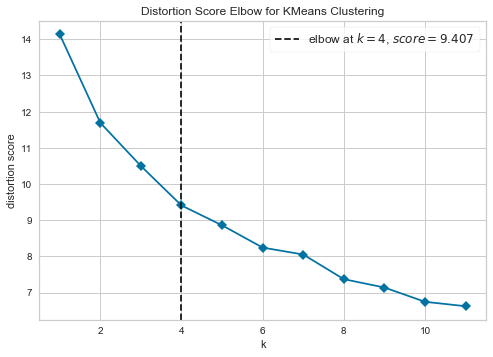

In [34]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12),timings=False)

visualizer.fit(cities_df_clustering)    
visualizer.show()

The resulting graph suggests that the optimal number of clusters is **4 clusters.**

In [35]:
# set number of clusters
kclusters = 4
# run k-means clustering
kmeanModel = KMeans(n_clusters=kclusters,n_init=30,max_iter=1000)
kmeanModel.fit(cities_df_clustering)
# add clustering labels
cities_df.insert(0, 'Cluster Labels', kmeanModel.labels_)

In [36]:
cities_clustered = pd.merge(cities_df[['Cluster Labels','Code']],
                     cities,
                     on = 'Code')
## Venues
cities_venues_sorted = pd.merge(cities_df[['Cluster Labels','Code']],
                                 cities_venues_sorted,
                                 on = 'Code')
##Schools
schools_gpe =pd.merge(cities_df[['Cluster Labels','Code']],
                              schools_gpe,
                              on = 'Code')

## hospitals
health_service = pd.merge(cities_df[['Cluster Labels','Code']],
                                 health_service,
                                 on = 'Code')

## Medical Professional
med_prof_gpe = pd.merge(cities_df[['Cluster Labels','Code']],
                                 med_prof_gpe,
                                 on = 'Code')


## 4.Results

In this section, we will visualize the resulting clusters and analyze their features.

### 4.1. Visualizing the results on the map

In [37]:
# create map
map_clusters = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=11 )

# set color scheme for the clusters
colors_array = ['red','yellow','blue','green']

# add markers to the map
markers_colors = []
for lat, lon, city, cluster in zip(cities_clustered['Latitude'], cities_clustered['Longitude'], cities_clustered['City'], cities_clustered['Cluster Labels']):
    label = folium.Popup(str(city) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors_array[cluster-1],
        fill=True,
        fill_color=colors_array[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

**Cluster 0**: Are marked with green circles.<br>
**Cluster 1**: Are marked with red circles.<br>
**Cluster 2**: Are marked with yellow circles.<br>
**Cluster 3**: Are marked with blue circles.<br>

### 4.2 .Analyzing the most common venues per cluster: 

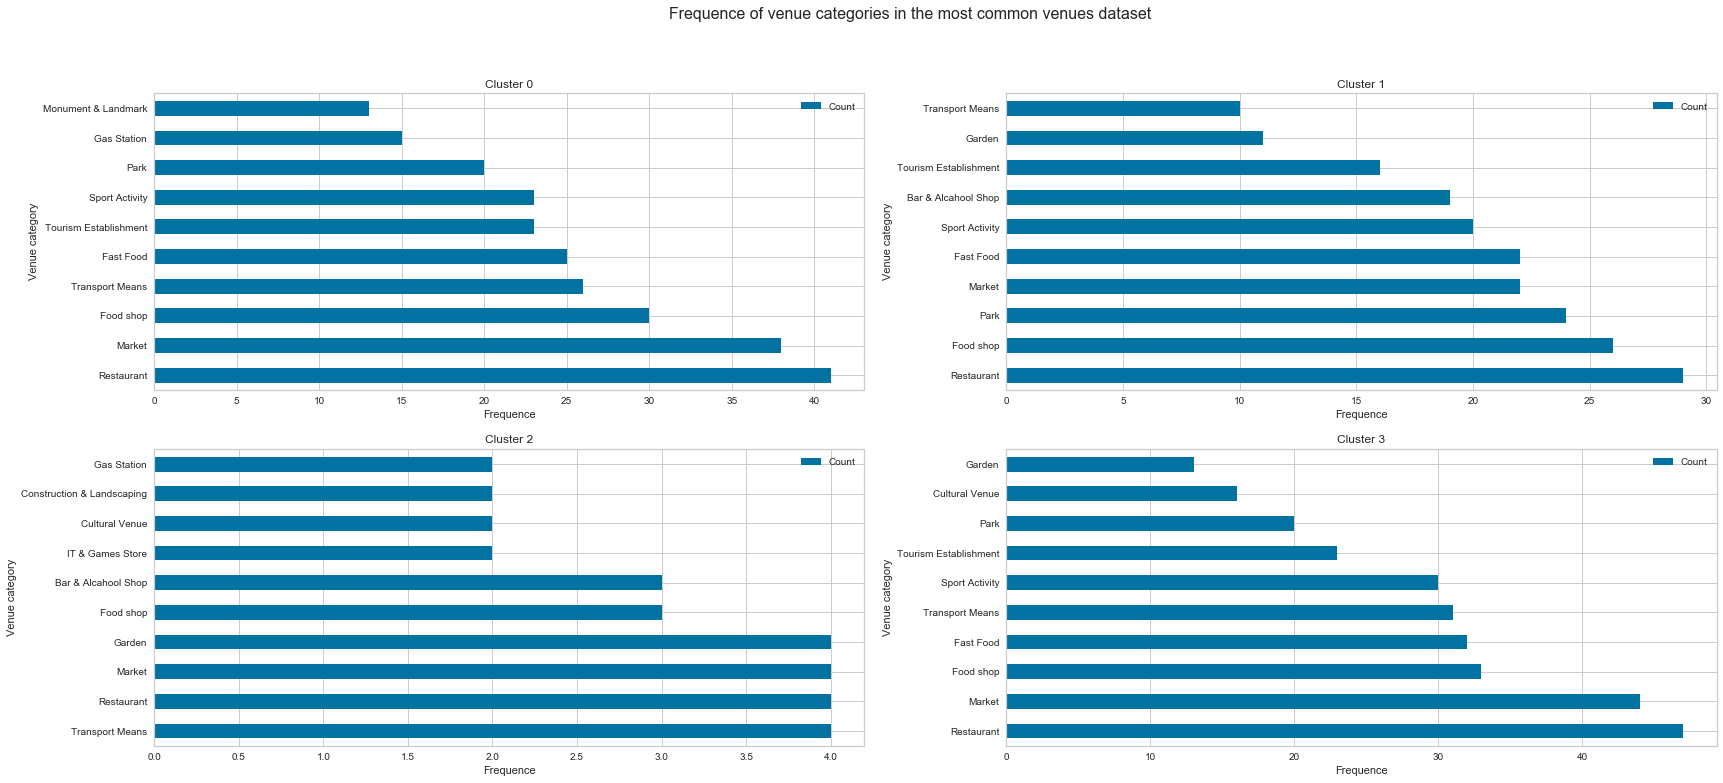

In [39]:
##Cluster 0
venues_cluster_0 = cities_venues_sorted.loc[cities_venues_sorted['Cluster Labels'] == 0,'1st Most Common Venue':].melt(var_name='columns', value_name='venue').groupby('venue').count().reset_index()
venues_cluster_0.columns = ['Venue Category','Count']
venues_cluster_0 = venues_cluster_0.sort_values(by='Count',ascending=False)

##Cluster 1
venues_cluster_1 = cities_venues_sorted.loc[cities_venues_sorted['Cluster Labels'] == 1,'1st Most Common Venue':].melt(var_name='columns', value_name='venue').groupby('venue').count().reset_index()
venues_cluster_1.columns = ['Venue Category','Count']
venues_cluster_1 = venues_cluster_1.sort_values(by='Count',ascending=False)

##Cluster 2
venues_cluster_2 = cities_venues_sorted.loc[cities_venues_sorted['Cluster Labels'] == 2,'1st Most Common Venue':].melt(var_name='columns', value_name='venue').groupby('venue').count().reset_index()
venues_cluster_2.columns = ['Venue Category','Count']
venues_cluster_2 = venues_cluster_2.sort_values(by='Count',ascending=False)

##Cluster 3
venues_cluster_3 = cities_venues_sorted.loc[cities_venues_sorted['Cluster Labels'] == 3,'1st Most Common Venue':].melt(var_name='columns', value_name='venue').groupby('venue').count().reset_index()
venues_cluster_3.columns = ['Venue Category','Count']
venues_cluster_3 = venues_cluster_3.sort_values(by='Count',ascending=False)

fig, axes = plt.subplots(nrows=2, ncols=2 , figsize=(28, 12))

venues_cluster_0.head(10).plot.barh('Venue Category','Count',ax=axes[0][0])
venues_cluster_1.head(10).plot.barh('Venue Category','Count',ax=axes[0][1])
venues_cluster_2.head(10).plot.barh('Venue Category','Count',ax=axes[1][0])
venues_cluster_3.head(10).plot.barh('Venue Category','Count',ax=axes[1][1])

axes[0][0].set_title('Cluster 0')
axes[0][0].set_ylabel('Venue category')
axes[0][0].set_xlabel('Frequence')

axes[0][1].set_title('Cluster 1')
axes[0][1].set_ylabel('Venue category')
axes[0][1].set_xlabel('Frequence')

axes[1][0].set_title('Cluster 2')
axes[1][0].set_ylabel('Venue category')
axes[1][0].set_xlabel('Frequence')

axes[1][1].set_title('Cluster 3')
axes[1][1].set_ylabel('Venue category')
axes[1][1].set_xlabel('Frequence')

fig.suptitle('Frequence of venue categories in the most common venues dataset', fontsize=16)
plt.savefig('./Img/Venue_Categories.png')


**Cluster 0**: As for the other clusters, restaurants, markets, and food shops are well spread in the municipalities of the inner suburbs of Ile-de-France. This cluster offers a good transport offer, in addition to tourist locations, parks and monuments. The cities of this cluster can be a tourist destination for people visiting Ile de France.<br>
**Cluster 1**: In addition to the 3 most popular venues in the municipalities of Île-de-France, the cities of this cluster, compared to the others, include several parks as well as spaces for sports activities. This cluster seems ideal for families wanting to settle down for the medium or long term.<br>
**Cluster 2**: This cluster is the one that has the most specificity compared to the 3 others. The most common amenities there are means of transport. And it also contains It & game stores, bar & alcohol shops, and gardens, which makes the municipalities of this cluster the most lively municipalities of the small crown.<br>
**Cluster 3**: in addition to the 3 most popular venues, the cities of this cluster give importance to fast food and transport, as well as sporting activities. We can imagine that the municipalities of this cluster can house companies.<br>

### 4.3.Analyzing the number of schools per cluster: 

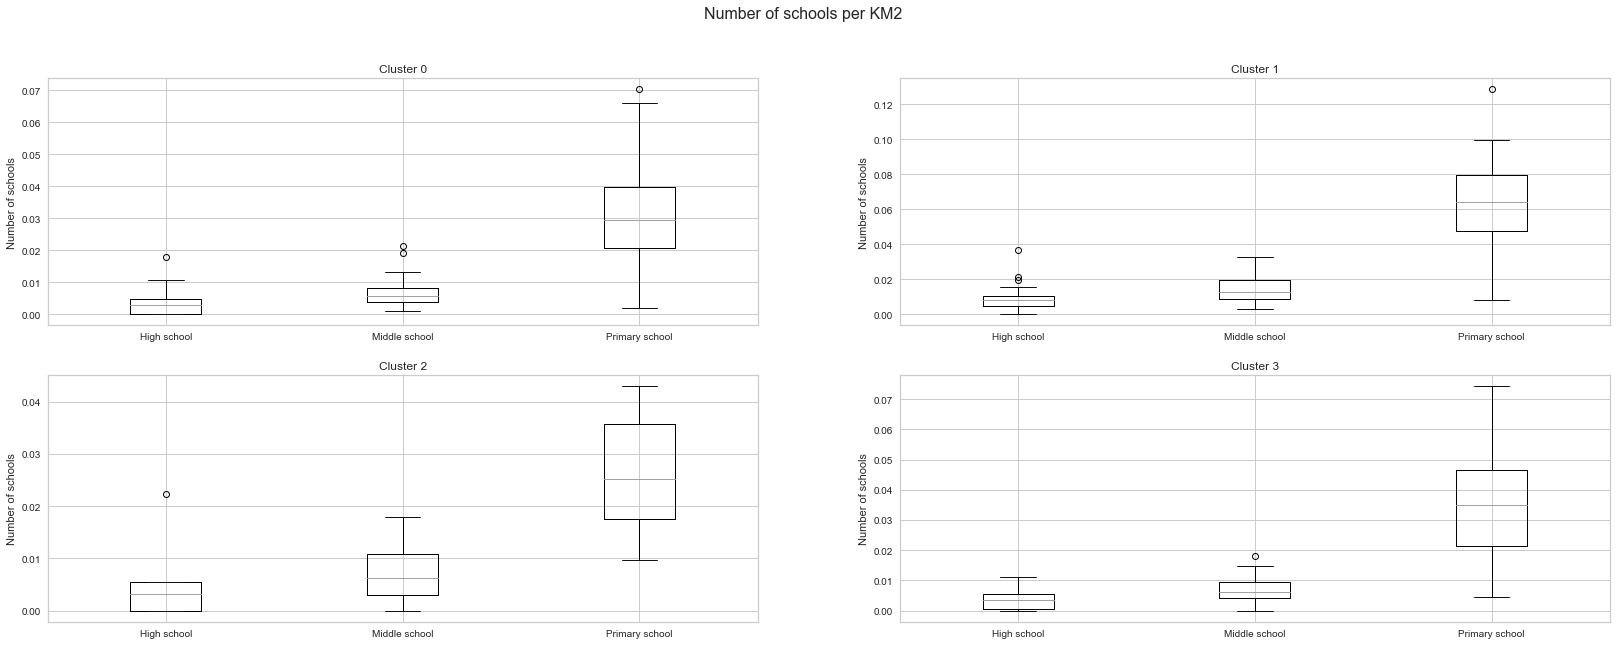

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(28, 10))

schools_gpe.loc[schools_gpe['Cluster Labels'] == 0,'City':].boxplot(column=['High school','Middle school','Primary school'],ax=axes[0][0])
schools_gpe.loc[schools_gpe['Cluster Labels'] == 1,'City':].boxplot(column=['High school','Middle school','Primary school'],ax=axes[0][1])
schools_gpe.loc[schools_gpe['Cluster Labels'] == 2,'City':].boxplot(column=['High school','Middle school','Primary school'],ax=axes[1][0])
schools_gpe.loc[schools_gpe['Cluster Labels'] == 3,'City':].boxplot(column=['High school','Middle school','Primary school'],ax=axes[1][1])

axes[0][0].set_title('Cluster 0')
axes[0][0].set_ylabel('Number of schools')

axes[0][1].set_title('Cluster 1')
axes[0][1].set_ylabel('Number of schools')

axes[1][0].set_title('Cluster 2')
axes[1][0].set_ylabel('Number of schools')

axes[1][1].set_title('Cluster 3')
axes[1][1].set_ylabel('Number of schools')

fig.suptitle('Number of schools per KM2', fontsize=16)
plt.savefig('./Img/SchoolsPerKM2.png')


In comparison, the cities in **cluster 1** are those with the largest number of schools in relation to their surface areas, this finding is consistent with the analysis made on the distribution of venues in the municipalities of the inner suburbs.
As only 25% of the cities of **cluster 1** have 0.035 primary schools per one $Km^2$ or less (i.e one school per 28.57 $Km^2$) and 75% have 0.065 primary schools per one $Km^2$ or less (i.e one school per 15.40 $Km^2$) on the opposite for the three other clusters more than 75% of their cities have less than 0.04 primary schools per one $Km^2$ or less (i.e one school per 25 $Km^2$).

### 4.3.Analyzing the number of health services per cluster: 

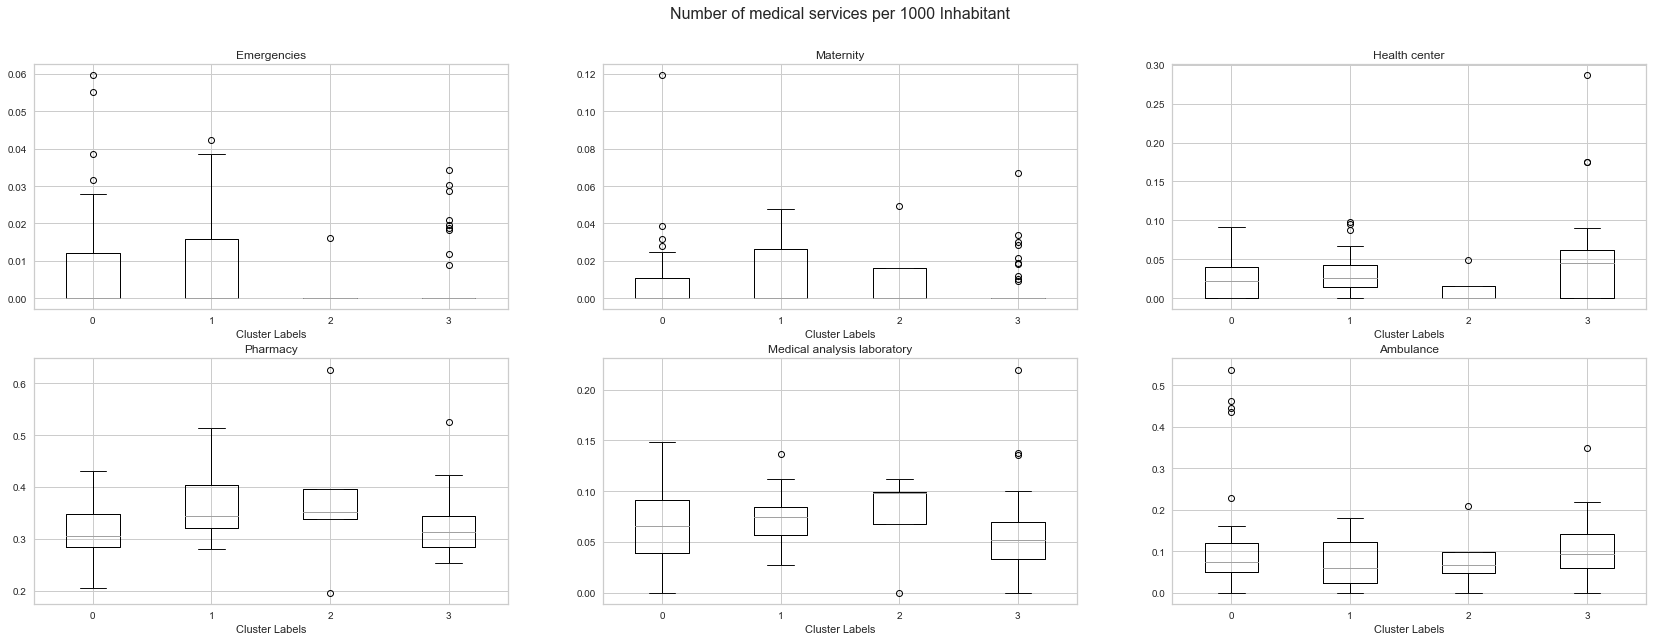

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(28, 10))

health_service.boxplot(column=['Emergencies'],by='Cluster Labels',ax=axes[0][0])
health_service.boxplot(column=['Maternity'],by='Cluster Labels',ax=axes[0][1])
health_service.boxplot(column=['Health center'],by='Cluster Labels',ax=axes[0][2])
health_service.boxplot(column=['Pharmacy'],by='Cluster Labels',ax=axes[1][0])
health_service.boxplot(column=['Medical analysis laboratory'],by='Cluster Labels',ax=axes[1][1])
health_service.boxplot(column=['Ambulance'],by='Cluster Labels',ax=axes[1][2])


fig.suptitle('Number of medical services per 1000 Inhabitant', fontsize=16)
plt.savefig('./Img/Health_Services.png')


From the emergency and maternity boxplots, we notice that more than 50% don't have these services we see also a lot of outliers. This may be because emergency and maternity services distribution is not done at the city level but at the department level, so we should exclude them from our analysis.
From the graph, despite a slight advantage of **cluster 2**, we can see that the distribution of pharmacies and medical analysis laboratories are similar for the clusters.
The distribution of ambulances is balanced between the 3 clusters. We can deduce that although hospitals and emergency services are centralized in some municipalities, ambulances are distributed fairly to serve them.

### 4.4.Analyzing the number of medical professionals per cluster: 

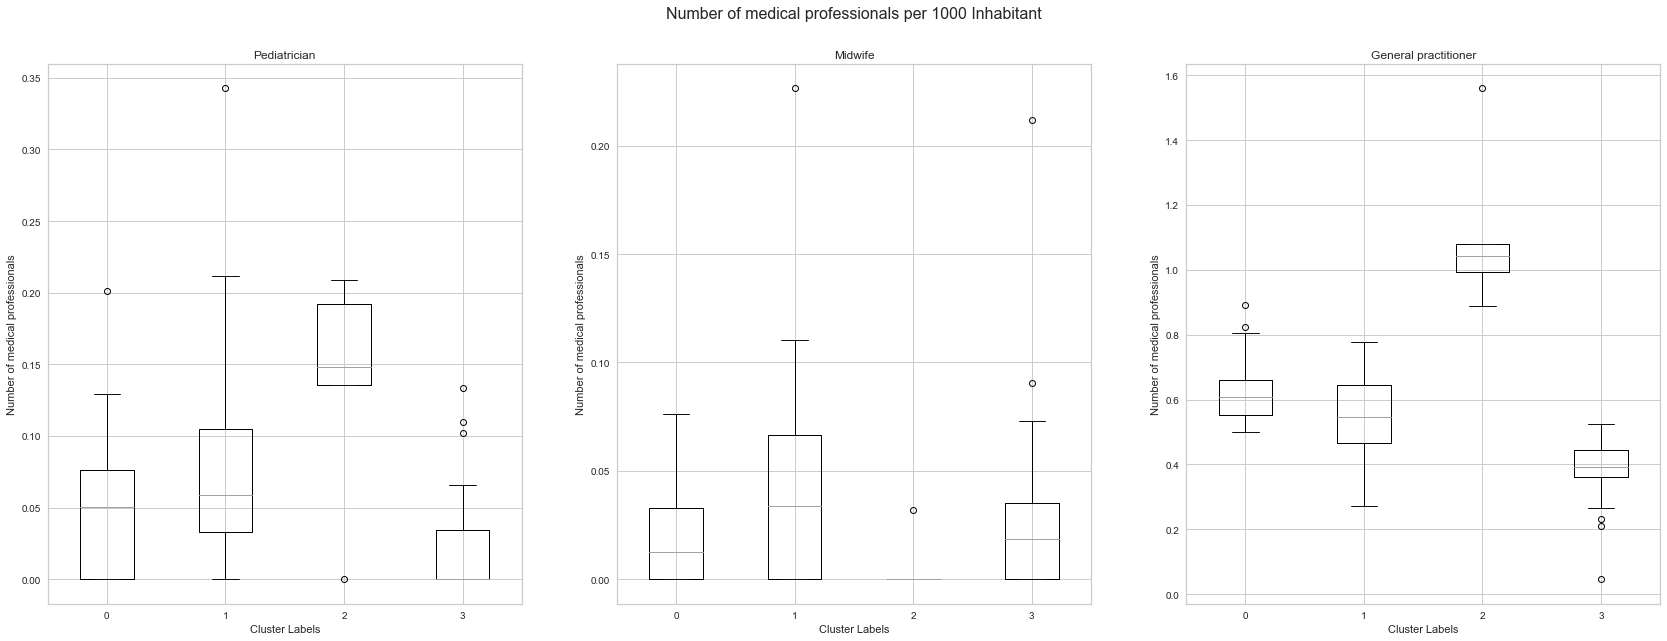

In [44]:
med_prof_gpe.loc[med_prof_gpe['Cluster Labels'] == 0,'City':].describe()



fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 10))

med_prof_gpe.boxplot(column=['Pediatrician'],by='Cluster Labels',ax=axes[0])
med_prof_gpe.boxplot(column=['Midwife'],by='Cluster Labels',ax=axes[1])
med_prof_gpe.boxplot(column=['General practitioner'],by='Cluster Labels',ax=axes[2])


axes[0].set_ylabel('Number of medical professionals')

axes[1].set_ylabel('Number of medical professionals')

axes[2].set_ylabel('Number of medical professionals')

fig.suptitle('Number of medical professionals per 1000 Inhabitant', fontsize=16)
plt.savefig('./Img/Health_Professionals.png')

From the box plot of the general practitioner the distribution is normal for each city with an interquartile region of a maximum 2 practitioner per 10000 inhabitants which imply that the cities of each cluster are very similar in term of general practitioner distribution. This boxplot also shows an advantage for **Cluster 2** with A median of 11 general practitioner per 10000 inhabitants whereas the **Clusters 0 and 1** counts an Upper Quartile of approximatly 7 per 10000 inhabitants.  

From the pediatricians' boxplot, we find that a large number of cities in **Cluster 0 and 3** have no pediatrician. **Cluster 2** has the highest number with a median of 0.15 pediatrician per 1000 inhabitants (1 pediatrician for all 6666 inhabitants).

The distribution of midwives follows the same logic as those of hospitals, in fact, this service is not generalized within the municipalities, but rather centralized taking advantage of the fact that the municipalities are adjacent to each other.

## 5.Discussion

Based on the various analyzes, we found that all the cities in the inner suburbs of Paris give an important place to restaurants, markets, food markets, and pharmacies. The availability of transport is also common in these municipalities.<br>
Concerning the medical service, the offer varies according to the service: certain services are centralized in certain municipalities, such as the emergency services, midwives, and pediatrics. On the other hand, other services are present in a fairly equitable manner in all the municipalities, notably pharmacies and the ambulance.
The choice of the city in which a person wants to settle will therefore focus mainly on other criteria, notably, the presence of gardens, parks, and sports activities, and the availability of schools.<br>
Based on the resulting clusters, the **Cluster 1** seems more suited for a Family with or planning to have children, as it has a large number of parks, gardens, and sport activities spaces. These municipalities also benefit from more schools compared to others.<br>
**Cluster 2** is distinguished from the other 3 by the presence of places of entertainment, these municipalities can be ideal for young people seeking an active life in their place of residence.<br>
Compared to other clusters, **Cluster 3** is the one with the best transport and fast food offerings, these two elements are characteristic of cities hosting a large number of companies, and consequently receiving a large number of employees every day.<br>
**Cluster 0** is the one with the largest number of tourist sites, it also has a significant transport offer. these towns can therefore be the target of tourists visiting the French capital.<br>

It should be noted that these cities are the most coveted by people wanting to settle around the French capital, so it is quite normal that the main facilities are available in all the municipalities.
To carry out this work, we used data from French official bodies, however, we were forced not to go too deep in our analysis because we did not have a certain level of detail, for example: speaking of hospitals, it would have been more judicious if we had the number of beds per hospital. Concerning schools, the number of classes and their capacity would have influenced our analyzes.

## 6.Conclusion

This study allowed us to have an idea about the categorization of the cities of this region, but, to have more convincing and more reliable results, it is necessary to take into consideration the future development plans of these cities and the demographic predictions.<br>
Choosing a city in which to settle is sometimes more complicated, choosing the district is even more so. Sometimes, all it takes is for a TGV or train line to pass behind a residential complex for it to lose a lot of its value. and in the opposite, the creation of a new metro stop or train station can transform the life and potential of a municipality.<br>
The number, quality, and precision of the data will allow the full potential of machine learning algorithms to be exploited, and by doing this work, I understand that, beyond the technical and coding aspects, knowledge and research in the field to be studied are necessary to carry out a study.